In [85]:
!pip install torchsummary

In [86]:
import torch
from torch import nn

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets
import torchvision.transforms as tr


In [87]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        #ВАШ_КОД
        self.conv2d_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1)        
        self.relu = nn.ReLU()
        self.maxpool2d_1 =  nn.MaxPool2d(kernel_size=2)
        
        self.conv2d_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)        
        self.maxpool2d_2 =  nn.MaxPool2d(kernel_size=2)
        
        self.conv2d_3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1)        
        self.maxpool2d_3 =  nn.MaxPool2d(kernel_size=2)
        


        self.fc_mu = torch.nn.Linear(latent_size, latent_size) #формирование вектора мат ожиданий
        self.fc_log_var = torch.nn.Linear(latent_size, latent_size) #формирование вектора логарифма дисперсий

        self.latent_size = latent_size

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        
        y = self.relu(self.conv2d_1(x))
        y = self.maxpool2d_1(y)
        y = self.relu(self.conv2d_2(y))
        y = self.maxpool2d_2(y)
        y = self.relu(self.conv2d_3(y))
        y = self.maxpool2d_3(y)

        #x = y.view(-1,self.latent_size) #делаем reshape, чтобы из сверточного слоя в полносвязку передать вектора
        #x = torch.flatten(y, start_dim=2)
        x = y.view(len(y),-1, self.latent_size)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var #результат энкодера -- это вектор средних и вектор дисперсий
        # ============

    def sample_latent(self, x): #получаем вектор скрытого состояния Z
        mu, log_var = self.forward(x) #получае вектора средних и дисперсий

        #torch.randn_like(input) Возвращает тензор случайных чисел из стандартного нормального распределения того же размера, что и input
        N = torch.randn_like(mu).to(device)

        #дисперсия у нас возвращается в логарифме, а умножить нам надо на стандартное отклонение
        #тогда нужно /2, степень уходит и взять экспоненту, получим просто стандартное отклонение
        return torch.exp(log_var/2) * N + mu, mu, log_var

In [88]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        #ВАШ_КОД
        self.convtr2d_1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3)
        self.relu = nn.ReLU()
        
        self.convtr2d_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3)
        self.upsample_1 = nn.Upsample(scale_factor=2)
        
        self.convtr2d_3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3)
        self.upsample_2 = nn.Upsample(scale_factor=2)
        
        self.convtr2d_4 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=5)


    def forward(self, x):

        x=x.view(len(x), 256,1,1)
        #ВАШ_КОД
        x = self.relu(self.convtr2d_1(x))
        y = self.relu(self.convtr2d_2(x))
        y = self.upsample_1(y)
        y = self.relu(self.convtr2d_3(y))
        y = self.upsample_2(y)
        y = torch.sigmoid(self.convtr2d_4(y))

        return y


In [89]:
def kl_l_f(logvar, mu):
    return - 0.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp())


In [90]:
def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()

    recon_loss_func = nn.BCELoss(reduction='sum')

    

    optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)

    loss_history = list()
    loss=0
    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):

            #ВАШ_КОД
            batch= batch.to(device)
            
            optimizer.zero_grad()
            
            reconstruction, mu, logvar = encoder.sample_latent(batch)

            #прямой проход через кодер и получение вектора Z, вектора средних и вектора дисперсий
            latent_vector, mu, log_sigma = encoder.sample_latent(batch)

            #получение ошибки MSE
            recon_loss = recon_loss_func(decoder(latent_vector), batch)

            #получение ошибки KL
            kl_loss = kl_l_f( log_sigma, mu)
            loss = kl_loss + 1000 * recon_loss # можно поварьировать балансировочный коэффициент

            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print('Потери восстановления:', recon_loss.item())
                print('Потери расхождения распределений:', kl_loss.item())
            loss_history.append(loss.detach().cpu().numpy())

        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
    # ============

    encoder.eval()
    decoder.eval()

    print('Готово!')

    plt.plot(loss_history)
    plt.show()

In [91]:
LATENT_SIZE = 2

BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

In [92]:
transform = tr.Compose([
    tr.ToTensor(),
])

In [93]:
#загрузить выбраные данные
#создать dataloader
MNIST_train=torchvision.datasets.MNIST('./data', download = True, train = True, transform=transform)
MNIST_test=torchvision.datasets.MNIST('./data', download = True, train = False, transform=transform)



In [94]:
train_loader = DataLoader(
    MNIST_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    MNIST_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Обучение автокодировщика..
Потери восстановления: 32994.3828125
Потери расхождения распределений: 1930.4073486328125
Потери восстановления: 10895.5537109375
Потери расхождения распределений: 18267.33984375
Потери восстановления: 7777.72265625
Потери расхождения распределений: 54771.9296875
Потери восстановления: 6503.208984375
Потери расхождения распределений: 63051.6484375
Потери восстановления: 6081.90478515625
Потери расхождения распределений: 66566.421875
Потери восстановления: 5616.1669921875
Потери расхождения распределений: 66644.953125
Потери восстановления: 5321.4228515625
Потери расхождения распределений: 69655.484375
Потери восстановления: 4880.16796875
Потери расхождения распределений: 66292.59375
Потери восстановления: 4890.4892578125
Потери расхождения распределений: 67473.1875
Потери восстановления: 4771.34765625
Потери расхождения распределений: 69266.7578125
Эпоха 1 / 10. Потери на последнем пакете: 2295086.25
Потери восстановления: 4859.2099609375
Потери расхождения р

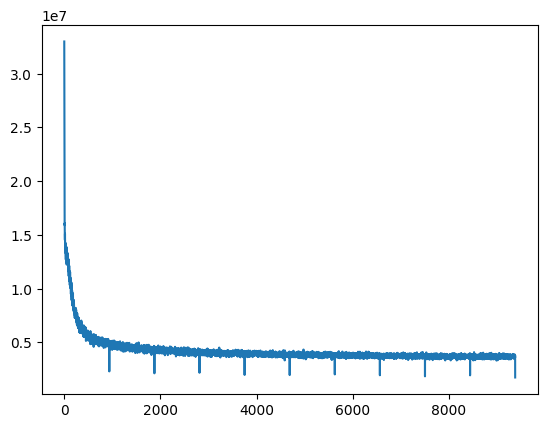

In [95]:
train_ae(train_loader, encoder, decoder, EPOCHS, LEARNING_RATE, device)

In [96]:
#по желанию можно использовать алгоритм уменьшение размерности,
#чтобы спроецировать скрытое пространство в 2d
#отправить в энкодер объекты, получить для каждого вектор скрытого состояния,
#полученные объекты изобразить

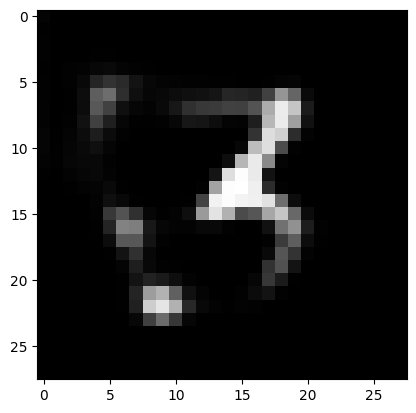

In [97]:
#сгенерировать новые объекты
#взять вектор из стандартного нормального распределения (torch.randn()) и отравить в декодер

x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

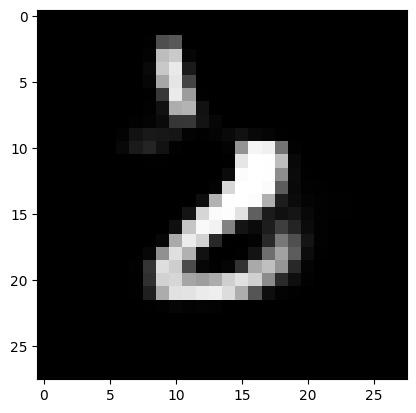

In [98]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

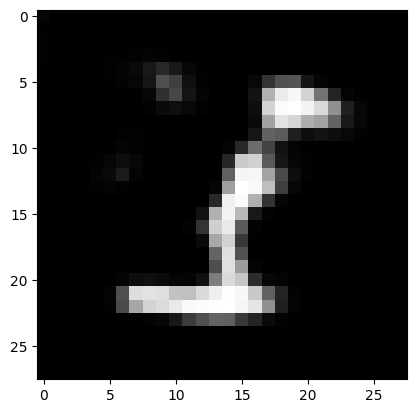

In [100]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

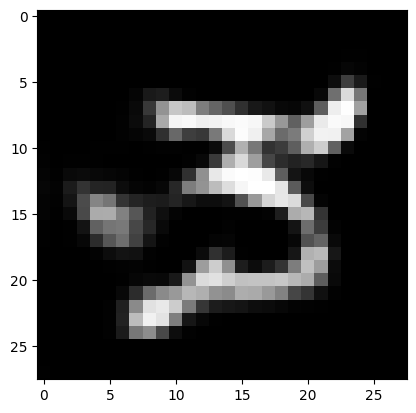

In [105]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

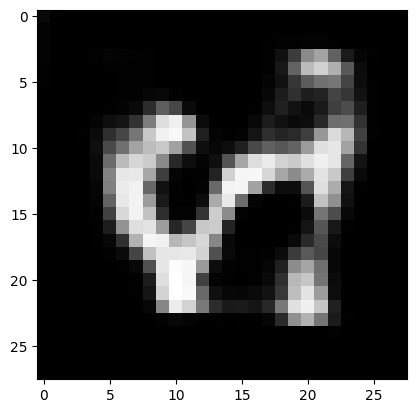

In [111]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

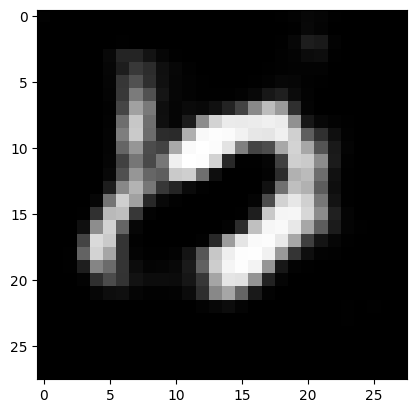

In [114]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

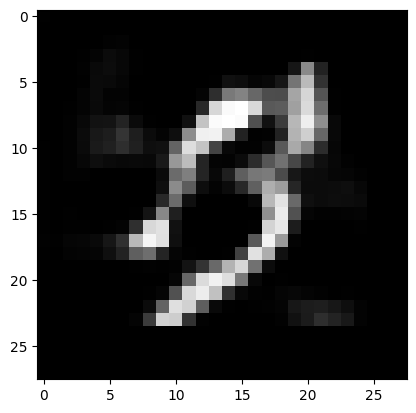

In [122]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

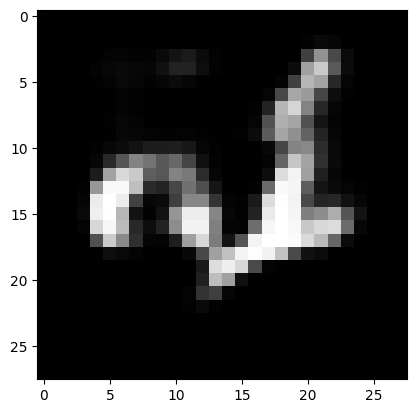

In [128]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

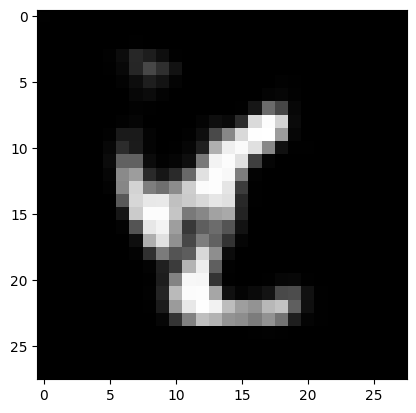

In [137]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

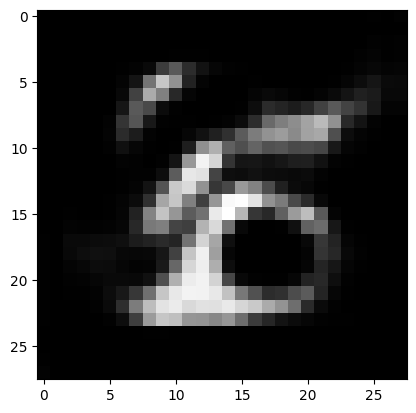

In [140]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

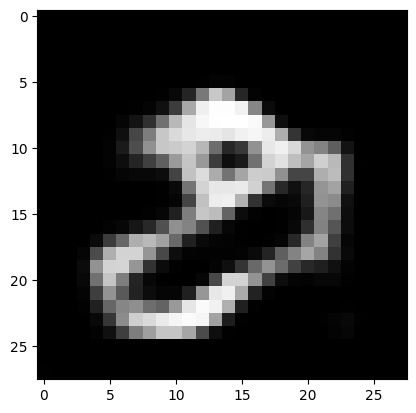

In [176]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

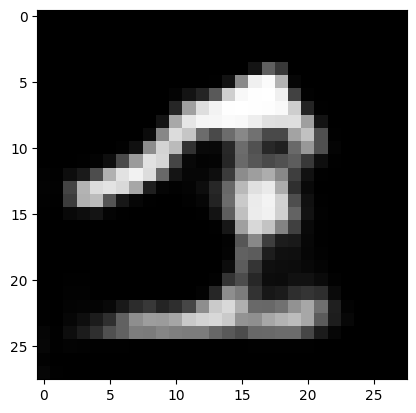

In [188]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

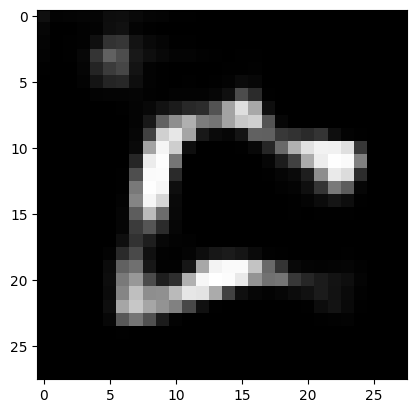

In [207]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

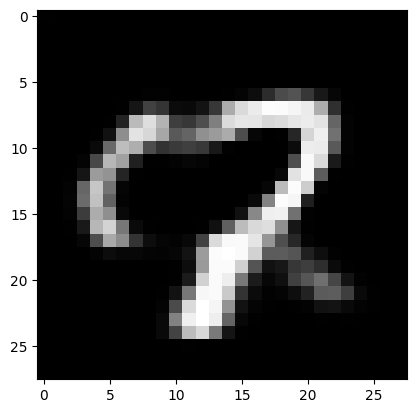

In [193]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')

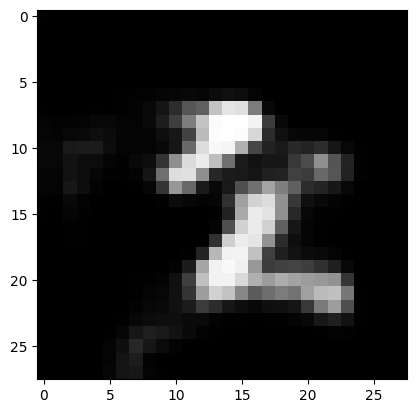

In [227]:
x_decoded = decoder(torch.randn(1,256,1,1).to(device))
digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
plt.imshow(digit, cmap='gray')